# Merge de dados

Aqui vamos fazer o merge dos dados de censo (setores e censo), e posteriormente fazer o merge com os dados dos imóveis.

In [ ]:
!pip install --upgrade fiona
!pip install --upgrade pyproj
!pip install --upgrade pyshp
!pip install --upgrade shapely
!pip install --upgrade descartes
!pip install --upgrade pandas
!pip install --upgrade folium
!pip install --upgrade xlrd
!sudo apt install libspatialindex-dev
!pip install --upgrade rtree

!pip install --upgrade geopandas

In [3]:
import geopandas as gpd
import pandas as pd
import folium

import os
import zipfile
import shutil

In [4]:
dir = '/content/drive/MyDrive/Programacao/GeoPandas/Dados/Dados_Modificados/'

rj = gpd.read_file(dir + 'RJ_Municipio/RJ_Municipio.shp')
imoveis = gpd.read_file(dir + 'Imoveis/Imoveis.shp')
setores_censo = gpd.read_file(dir + 'Setor_censitario/Setor_censitario.shp')

## Leitura dos dados do censo

In [5]:
dir = '/content/drive/MyDrive/Programacao/GeoPandas/Dados/Censo/RJ/Basico_RJ.xls'

df_censo = pd.read_excel(dir)
df_censo.head(1)

,Cod_setor,Cod_Grandes Regiões,Nome_Grande_Regiao,Cod_UF,Nome_da_UF,Cod_meso,Nome_da_meso,Cod_micro,Nome_da_micro,Cod_RM,Nome_da_RM,Cod_municipio,Nome_do_municipio,Cod_distrito,Nome_do_distrito,Cod_subdistrito,Nome_do_subdistrito,Cod_bairro,Nome_do_bairro,Situacao_setor,Tipo_setor,V001,V002,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
0,330010005000001,3,Região Sudeste,RJ,Rio de Janeiro,3305,Sul Fluminense,33013,Baía da Ilha Grande,0,Municípios não pertencentes a estrutura de RM,3300100,ANGRA DOS REIS,330010005,ANGRA DOS REIS,33001000500,ANGRA DOS REIS,3300100010,CENTRO,1,0,156.0,409.0,2.62,1.94,2356.8,5716056.06,2571.06,5684616.94,1565.37,4344465.56,2192.65,4711305.89


In [6]:
setores_censo.head(1)

,ID1,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODD,NM_DISTRIT,CD_GEOCODS,NM_SUBDIST,CD_GEOCODM,NM_MUNICIP,NM_MESO,NM_MICRO,geometry
0,400678,330455705080070,URBANO,330455705006,Rio Comprido,330455705,RIO DE JANEIRO,330455705,RIO COMPRIDO,3304557,RIO DE JANEIRO,METROPOLITANA DO RIO DE JANEIRO,RIO DE JANEIRO,"POLYGON ((683.095 7463.995, 683.081 7464.013, ..."


A Coluna CD_GEOCODI do gdf setores_censo é a coluna Cod_setor do df df_censo.
- CD_GEOCODI do setores_censo: object (string)
- Cod_setor do df_censo: int64

Vamos modificar o formato int64 para string:

In [7]:
df_censo['Cod_setor'] = df_censo['Cod_setor'].astype('str')

## Merge dos setores censitários com dados do censo

Com os dados no mesmo formato, vamos fazer o merge dos dois dataframes:

In [8]:
dados_censo = pd.merge(setores_censo, df_censo, left_on='CD_GEOCODI', right_on='Cod_setor', how='left')

# left: setores_censo
# right: df_censo

In [9]:
print("Formato:", dados_censo.shape)
print("Tipo:", type(dados_censo))

Formato: (10504, 47)
Tipo: <class 'geopandas.geodataframe.GeoDataFrame'>


In [10]:
# Save do novo df com todos os dados de censo:

dados_censo.to_file('/content/drive/MyDrive/Programacao/GeoPandas/Dados/Dados_Modificados/Setor_censitario/Dados_censo.shp')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  This is separate from the ipykernel package so we can avoid doing imports until


## Merge dos dados do censo com os dados dos imóveis

In [11]:
dados_censo.head(1)

,ID1,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODD,NM_DISTRIT,CD_GEOCODS,NM_SUBDIST,CD_GEOCODM,NM_MUNICIP,NM_MESO,NM_MICRO,geometry,Cod_setor,Cod_Grandes Regiões,Nome_Grande_Regiao,Cod_UF,Nome_da_UF,Cod_meso,Nome_da_meso,Cod_micro,Nome_da_micro,Cod_RM,Nome_da_RM,Cod_municipio,Nome_do_municipio,Cod_distrito,Nome_do_distrito,Cod_subdistrito,Nome_do_subdistrito,Cod_bairro,Nome_do_bairro,Situacao_setor,Tipo_setor,V001,V002,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
0,400678,330455705080070,URBANO,330455705006,Rio Comprido,330455705,RIO DE JANEIRO,330455705,RIO COMPRIDO,3304557,RIO DE JANEIRO,METROPOLITANA DO RIO DE JANEIRO,RIO DE JANEIRO,"POLYGON ((683.095 7463.995, 683.081 7464.013, ...",330455705080070,3.0,Região Sudeste,RJ,Rio de Janeiro,3306.0,Metropolitana do Rio de Janeiro,33018.0,Rio de Janeiro,19.0,RM Rio de Janeiro,3304557.0,RIO DE JANEIRO,330455705.0,RIO DE JANEIRO,3.304557e+10,RIO COMPRIDO,3.304557e+09,Rio Comprido,1.0,0.0,169.0,491.0,2.91,2.06,3149.14,7515356.37,3206.05,7468430.45,1970.58,5332244.66,2501.34,5441140.47


In [12]:
imoveis.head(1)

,Area,Bairro,Cidade,Endereco,Estado,Latitude,Longitude,Quartos,Suites,Vagas,Tipo,Transacao,Valor,Dist_Metro,Dist_Trem,Dist_BRT,Dist_Trans,Dist_Praia,geometry
0,138,Recreio dos Bandeirantes,Rio de Janeiro,Rua Vicente Scofano,RJ,-23.016455,-43.462946,3,1,3,Apartamento,Venda,1095000,15.622939,15.627477,0.443193,0.443193,1.143453,POINT (657.514 7453.832)


## Plot dos dois dataframes

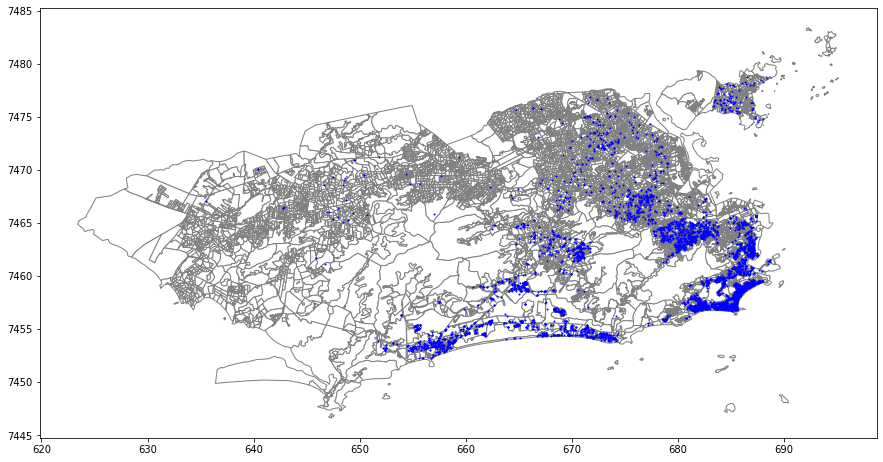

In [13]:
base = dados_censo.plot(color='white', edgecolor='gray', figsize=(15,15))
imoveis.plot(ax=base, color='blue', markersize=1)

In [30]:
geo_dados = gpd.sjoin(imoveis, dados_censo, how='left', op='within')

In [15]:
geo_dados.head(1)

,Area,Bairro,Cidade,Endereco,Estado,Latitude,Longitude,Quartos,Suites,Vagas,Tipo,Transacao,Valor,Dist_Metro,Dist_Trem,Dist_BRT,Dist_Trans,Dist_Praia,geometry,index_right,ID1,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODD,NM_DISTRIT,CD_GEOCODS,NM_SUBDIST,CD_GEOCODM,NM_MUNICIP,NM_MESO,NM_MICRO,Cod_setor,Cod_Grandes Regiões,Nome_Grande_Regiao,Cod_UF,Nome_da_UF,Cod_meso,Nome_da_meso,Cod_micro,Nome_da_micro,Cod_RM,Nome_da_RM,Cod_municipio,Nome_do_municipio,Cod_distrito,Nome_do_distrito,Cod_subdistrito,Nome_do_subdistrito,Cod_bairro,Nome_do_bairro,Situacao_setor,Tipo_setor,V001,V002,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
0,138,Recreio dos Bandeirantes,Rio de Janeiro,Rua Vicente Scofano,RJ,-23.016455,-43.462946,3,1,3,Apartamento,Venda,1095000,15.622939,15.627477,0.443193,0.443193,1.143453,POINT (657.514 7453.832),9431,409857,330455705290331,URBANO,330455705135,Recreio dos Bandeirantes,330455705,RIO DE JANEIRO,330455705,BARRA DA TIJUCA,3304557,RIO DE JANEIRO,METROPOLITANA DO RIO DE JANEIRO,RIO DE JANEIRO,330455705290331,3.0,Região Sudeste,RJ,Rio de Janeiro,3306.0,Metropolitana do Rio de Janeiro,33018.0,Rio de Janeiro,19.0,RM Rio de Janeiro,3304557.0,RIO DE JANEIRO,330455705.0,RIO DE JANEIRO,3.304557e+10,BARRA DA TIJUCA,3.304557e+09,Recreio dos Bandeirantes,1.0,0.0,131.0,357.0,2.73,1.26,7337.38,1.587736e+08,7628.55,1.628856e+08,4098.24,81102256.68,5808.81,105121680.2


## Seleção dos dados não duplicados

Alguns dados foram duplicados pois um imóvel pode cair em uma fronteira entre dois setores censitários, vamos eliminar uma entrada duplicada.

Quando um dado é duplicado, seu index também é duplicado.

In [31]:
geo_dados.shape

(4516, 66)

In [32]:
duplicados = geo_dados.index.duplicated(keep='first')
duplicados # array de indices duplicados

array([False, False, False, ..., False, False, False])

In [33]:
manter = []
for idx in duplicados:
    manter.append(not idx)

manter[:5] # array de indices a serem mantidos no dataframe

[True, True, True, True, True]

In [34]:
geo_dados = geo_dados[manter] ## seleciona apenas os a manter
geo_dados.shape

(4513, 66)

## Save do dataframe com todos os dados

In [37]:
dir = '/content/drive/MyDrive/Programacao/GeoPandas/Dados/Dados_Modificados/Dados_agregados'
if not os.path.exists(dir):
    os.makedirs(dir)

geo_dados.to_file(dir + '/Dados_agregados.shp')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """
